# lenstronomy numerics
In this notebook we use the different convolution and super-sampling approximations in lenstronomy. The different approximations are described and demonstrated on the use-case of a single Sersic profile. The example is also been used to compare the computational speed and accuracy of the different approximations. Please note that performance and accuracy depend on the specific use case and an optimal choice is upon the discretion and responsibility of the user.

In [1]:
import numpy as np
import os
import time
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
%matplotlib inline

import lenstronomy.Util.util as util
import lenstronomy.Util.kernel_util as kernel_util

## set up the example
We use a single elliptical Sersic profile and a TinyTim PSF as our example.

135


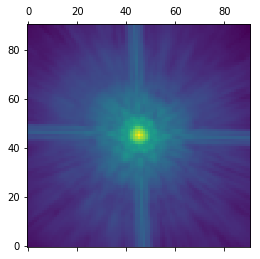

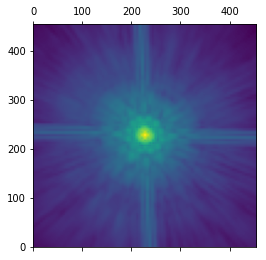

In [2]:
# we define a model consisting of a singe Sersric profile
from lenstronomy.LightModel.light_model import LightModel
light_model_list = ['SERSIC_ELLIPSE']
lightModel = LightModel(light_model_list=light_model_list)
kwargs_light = [{'amp': 100, 'R_sersic': 0.5, 'n_sersic': 3, 'e1': 0, 'e2': 0, 'center_x': 0.02, 'center_y': 0}]

# we define a pixel grid and a higher resolution super sampling factor
supersampling_factor = 5
numPix = 61  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
x, y, ra_at_xy_0, dec_at_xy_0, x_at_radec_0, y_at_radec_0, Mpix2coord, Mcoord2pix = util.make_grid_with_coordtransform(
            numPix=numPix, deltapix=deltaPix, subgrid_res=1, left_lower=False, inverse=False)
flux = lightModel.surface_brightness(x, y, kwargs_list=kwargs_light)
flux = util.array2image(flux)
flux_max = np.max(flux)
conv_pixels_partial = np.zeros((numPix, numPix), dtype=bool)
conv_pixels_partial[flux >= flux_max/20] = True
print(np.sum(conv_pixels_partial))


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

kernel_size = 91
kernel_super = kernel_util.subgrid_kernel(kernel=kernel, num_iter=10, subgrid_res=supersampling_factor, odd=True)
kernel_cut = kernel_util.cut_psf(psf_data=kernel, psf_size=kernel_size)
kernel_super = kernel_util.cut_psf(psf_data=kernel_super, psf_size=kernel_size*supersampling_factor)


plt.matshow(np.log(kernel_cut), origin='lower')
plt.show()

plt.matshow(np.log(kernel_super), origin='lower')
plt.show()

# make instance of the PixelGrid class
from lenstronomy.Data.pixel_grid import PixelGrid
kwargs_grid = {'nx': numPix, 'ny': numPix, 'transform_pix2angle': Mpix2coord, 'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0}
pixel_grid = PixelGrid(**kwargs_grid)

# make instance of the PSF class
from lenstronomy.Data.psf import PSF
kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': kernel_super, 'point_source_supersampling_factor': supersampling_factor}
psf_class = PSF(**kwargs_psf)




## computing convolved image with different numerical settings
Now we define different numerical settings, kwargs_numerics, that are imported into the ImageModel class to perform the image computation.

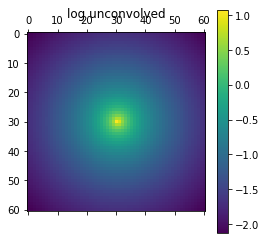

61.3 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


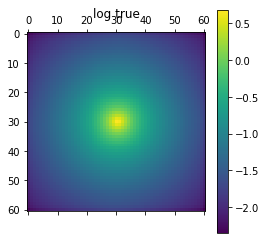

14.1 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


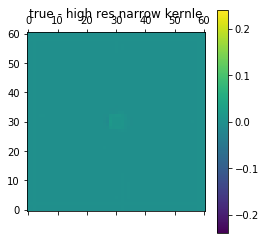

5.2 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


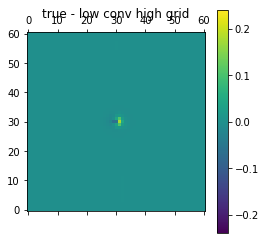

2.05 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


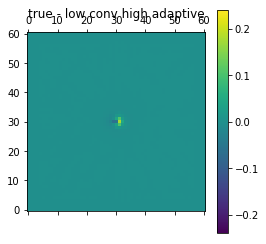

3.2 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


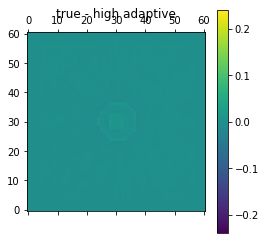

1.11 ms ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


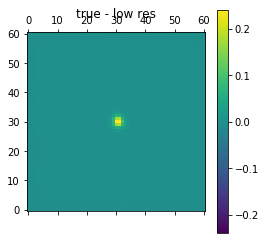

In [3]:
timeit = True  # profiling boolean

# high resolution ray-tracing and high resolution convolution, the full calculation
kwargs_numerics_true = {'supersampling_factor': supersampling_factor, # super sampling factor of (partial) high resolution ray-tracing
                        'compute_mode': 'regular', # 'regular' or 'adaptive'
                        'supersampling_convolution': True,  # bool, if True, performs the supersampled convolution (either on regular or adaptive grid)
                        'supersampling_kernel_size': None,  # size of the higher resolution kernel region (can be smaller than the original kernel). None leads to use the full size
                        'flux_evaluate_indexes': None,  # bool mask, if None, it will evaluate all (sub) pixels
                        'supersampled_indexes': None,  # bool mask of pixels to be computed in supersampled grid (only for adaptive mode)
                        'compute_indexes': None,  # bool mask of pixels to be computed the PSF response (flux being added to). Only used for adaptive mode and can be set =likelihood mask.
                        'point_source_supersampling_factor': 1,  # int, supersampling factor when rendering a point source (not used in this script)
                       }


# high resolution convolution on a smaller PSF with low resolution convolution on the edges of the PSF and high resolution ray tracing
kwargs_numerics_high_res_narrow = {'supersampling_factor': supersampling_factor,
                        'compute_mode': 'regular',
                        'supersampling_convolution': True,
                        'supersampling_kernel_size': 5, 
                       }


# low resolution convolution based on high resolution ray-tracing grid
kwargs_numerics_low_conv_high_grid = {'supersampling_factor': supersampling_factor,
                        'compute_mode': 'regular',
                        'supersampling_convolution': False,  # does not matter for supersampling_factor=1
                        'supersampling_kernel_size': None,  # does not matter for supersampling_factor=1
                       }


# low resolution convolution with a subset of pixels with high resolution ray-tracing
kwargs_numerics_low_conv_high_adaptive = {'supersampling_factor': supersampling_factor,
                        'compute_mode': 'adaptive',
                        'supersampling_convolution': False,  # does not matter for supersampling_factor=1
                        'supersampling_kernel_size': None,  # does not matter for supersampling_factor=1
                        'supersampled_indexes': conv_pixels_partial,
                       }


# low resolution convolution with a subset of pixels with high resolution ray-tracing and high resoluton convolution on smaller kernel size
kwargs_numerics_high_adaptive = {'supersampling_factor': supersampling_factor,
                        'compute_mode': 'adaptive',
                        'supersampling_convolution': True,  # does not matter for supersampling_factor=1
                        'supersampling_kernel_size': 5,  # does not matter for supersampling_factor=1
                        'supersampled_indexes': conv_pixels_partial,
                       }


# low resolution convolution and low resolution ray tracing, the simplest calculation
kwargs_numerics_low_res = {'supersampling_factor': 1,
                        'compute_mode': 'regular',
                        'supersampling_convolution': False,  # does not matter for supersampling_factor=1
                        'supersampling_kernel_size': None,  # does not matter for supersampling_factor=1
                       }


from lenstronomy.ImSim.image_model import ImageModel

# without convolution
image_model_true = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_true)
image_unconvolved = image_model_true.image(kwargs_lens_light=kwargs_light, unconvolved=True)
plt.matshow(np.log10(image_unconvolved))
plt.title('log unconvolved')
plt.colorbar()
plt.show()



# True computation

image_true = image_model_true.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_true.image(kwargs_lens_light=kwargs_light)

vmin = np.min(image_true)/20
vmax = np.max(image_true)/20
plt.matshow(np.log10(image_true))
plt.title('log true')
plt.colorbar()
plt.show()

# high_res_narrow
image_model_high_res_narrow = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_high_res_narrow)
image_high_res_narrow = image_model_high_res_narrow.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_high_res_narrow.image(kwargs_lens_light=kwargs_light)

plt.matshow(image_true - image_high_res_narrow, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('true - high res narrow kernle')
plt.colorbar()
plt.show()

# low_conv_high_grid
image_model_low_conv_high_grid = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_low_conv_high_grid)
image_low_conv_high_grid = image_model_low_conv_high_grid.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_low_conv_high_grid.image(kwargs_lens_light=kwargs_light)

plt.matshow(image_true - image_low_conv_high_grid, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('true - low conv high grid')
plt.colorbar()
plt.show()


# low_conv_high_adaptive
image_model_low_conv_high_adaptive = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_low_conv_high_adaptive)
image_low_conv_high_adaptive = image_model_low_conv_high_adaptive.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_low_conv_high_adaptive.image(kwargs_lens_light=kwargs_light)

plt.matshow(image_true - image_low_conv_high_adaptive, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('true - low conv high adaptive')
plt.colorbar()
plt.show()


# high_adaptive
image_model_high_adaptive = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_high_adaptive)
image_high_adaptive = image_model_high_adaptive.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_high_adaptive.image(kwargs_lens_light=kwargs_light)

plt.matshow(image_true - image_high_adaptive, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('true - high adaptive')
plt.colorbar()
plt.show()


# low_res
image_model_low_res = ImageModel(pixel_grid, psf_class, lens_light_model_class=lightModel, kwargs_numerics=kwargs_numerics_low_res)
image_low_res = image_model_low_res.image(kwargs_lens_light=kwargs_light)
if timeit is True:
    %timeit image_model_low_res.image(kwargs_lens_light=kwargs_light)

plt.matshow(image_true - image_low_res, origin='lower', vmin=-vmax, vmax=vmax)
plt.title('true - low res')
plt.colorbar()
plt.show()